# How we calculate the reflectivity of a slab model

The slab model models the propagation of the neutron wave through a series of layers using the Abelès matrix formalism for stratified media {cite}`abeles_sur_1948,parratt_surface_1954`. 
Here, we will look closely at the algorithm used in this formalism in order to calculate the model reflectometry data. 

We will implement this in Python as we go, as a series of functions that we can bring together at the end.
This implementation is taken from the `refnx` package {cite}`nelson_refnx_2019`, and is reproduced under the BSD-3 License.
Most reflectometry analysis packages implement a similar algorithm.
First we will import the necessary Python packages.
````{margin}
```{note}
Additionally, for each of the functions the shape of the input parameters and returned values have been included in the docstring, to aid understanding.
```
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Model algorithm

This approach considers each $q$-value individually and constructs a series of matrices do describe each layer, $n$. 
The wavevector normal to the surface, $k(n)$, in each layer is found, 

$$ k_n(q) = \sqrt{k_0(q)^2 - 4\pi(\beta_n - \beta_0)},$$

where, $k_0(q) = 0.5q$, and $\beta_n$ and $\beta_0$ are the scattering length densities in layer $n$ and the superphase, layer $0$. 

In [2]:
def normal_wavevectors(q: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    :param q: array of q-wavevectors, shape: (number_q)
    :param beta: array of scattering length densities, shape: (number_layers)
    :return: wavevectors normal to surface, shape: (number_q, number_layers)
    """
    k0 = 0.5 * q[:, np.newaxis] 
    kn = np.sqrt(k0 ** 2 - 4.0 * np.pi * (beta - beta[0]))
    return kn

The $k_n(q)$ for each interface between two layers, a Frensel reflectance, $r_{n, n+1}(q)$, can be determined as,

$$r_{n, n+1}(q) = \frac{k_n(q) - k_{n+1}(q)}{k_n(q) + k_{n+1}(q)}. $$

In [3]:
def fresnel_reflectance(kn: np.ndarray) -> np.ndarray:
    """
    :param kn: wavevectors normal to surface, shape: (number_q, number_layers)
    :return: fresnel reflectance between layers, shape: (number_q, number_layers-1)
    """
    return (kn[:, :-1] - kn[:, 1:]) / (kn[:, :-1] + kn[:, 1:])

Additionally, the phase factor, $\phi_n(q)$, can be found as, 

$$ \phi_n(q) = \mathit{i} k_n(q) d_n, $$
$$ \phi_0(q) = 0. $$

In [4]:
def phase_factor(kn:np.ndarray, d: np.ndarray) -> np.ndarray:
    """
    :param kn: wavevectors normal to surface, shape: (number_q, number_layers)
    :param d: layer thicknesses, shape: (number_layers)
    :return: phase factor, shape: (number_q, number_layers)
    """
    phi_t = kn * d
    phi_t[:, 0] = np.zeros(kn.shape[0])
    return phi_t

The Fresnel reflectance and phase factor can be brought together to give a characteristic matrix for the interface between each layer, $M_{n, n+1}$,

$$M_{n, n+1}(q) = 
\begin{bmatrix} 
\exp \phi_n(q) & r_{n, n+1}\exp -\phi_n(q) \\
r_{n, n+1}\exp \phi_n(q) & \exp -\phi_n(q) 
\end{bmatrix}.
$$

In [5]:
def characteristic_matrices(r: np.ndarray, phi: np.ndarray) -> np.ndarray:
    """
    :param r: Fresnel reflectances, shape: (number_q, number_layers-1)
    :param phi: phase factors, shape: (number_q, number_layers-1)
    :returns: characteristic matrices, shape: (2, 2, number_q, number_layers-1)
    """
    M = np.ones((2, 2, *r.shape), dtype=complex)
    M[0, 0, :, 1:] = np.exp(1j * phi[:, 1:-1])
    M[1, 1, :, 1:] = np.exp(-1j * phi[:, 1:-1])
    M[1, 0] = r * M[0, 0]
    M[0, 1] = r * M[1, 1]
    return M

The resultant matrix for each $q$-vector, $B(q)$, can then be found from the product sum of all the characteristic matrices, 

$$ B(q) = \prod^{n_{\mathrm{max}}-1}_{n=0} M_{n, n+1}(q). $$

In [6]:
def resultant_matrix(M: np.ndarray) -> np.ndarray:
    """
    :param M: characteristic matrices, shape: (2, 2, number_q, number_layers-1)
    :return: resultant matrix, shape: (2, 2, number_q)
    """
    B = M[:, :, :, 0]
    for i in range(1, M.shape[-1]):
        p0 = B[0, 0] * M[0, 0, :, i] + B[1, 0] * M[0, 1, :, i]
        p1 = B[0, 0] * M[1, 0, :, i] + B[1, 0] * M[1, 1, :, i]
        B[0, 0] = p0
        B[1, 0] = p1

        p0 = B[0, 1] * M[0, 0, :, i] + B[1, 1] * M[0, 1, :, i]
        p1 = B[0, 1] * M[1, 0, :, i] + B[1, 1] * M[1, 1, :, i]
        B[0, 1] = p0
        B[1, 1] = p1
    return B

This product sum describes the reflectance and transmittance propagated through all of the interfaces. 
The overall reflectance and reflectivity is then calculated as, 

$$ r(q) = \frac{B_{0, 1}(q)}{B_{0, 0}(q)} $$
$$ R(q) = r(q) \bar{r}(q),$$

where, $\bar{r}(q)$ is the complex conjugate of $r(q)$. 

In [7]:
def reflectivity(B: np.ndarray) -> np.ndarray:
    """
    :param B: resultant matrix, shape: (2, 2, number_q)
    :return: reflectivity, shape: (number_q)
    """
    r = B[0, 1] / B[0, 0]
    return np.real(r * np.conj(r))

This is all brought together in the function below. 

In [8]:
def abeles(q: np.ndarray, beta: np.ndarray, d: np.ndarray) -> np.ndarray:
    """
    :param q: array of q-wavevectors, shape: (number_q)
    :param beta: array of scattering length densities, shape: (number_layers)
    :param d: layer thicknesses, shape: (number_layers)
    :returns: calculated reflectivity, shape: (number_q)
    """
    kn = normal_wavevectors(q, beta)
    phi = phase_factor(kn, d)
    r = fresnel_reflectance(kn)
    M = characteristic_matrices(r, phi)
    B = resultant_matrix(M)
    return reflectivity(B)

Then, we can compare the result from the application of the Abelès matrix formalism for stratified media to that from the Fourier transform shown previously. 

In [9]:
# Abeles method
q = np.linspace(0.001, 0.2, 500)
beta = np.array([0 + 0j, 4.186e-6 + 0j, 2.871e-6 + 0j])
d = np.array([0, 200, 0])
r_abeles = abeles(q, beta, d)

# Fourier transform
z = np.linspace(-20, 300, 1000)
rho = np.zeros_like(z)
rho[np.where((z > 0) & (z < 200))] = 4.186e-6
rho[np.where(z > 200)] = 2.871e-6
f = (np.diff(rho) * np.exp(
    -1j * z[:-1] * q[:, np.newaxis])).sum(-1)
r_fourier = 16 * np.pi ** 2 / (q ** 4) * np.square(np.abs(f))

The results are plotted below. 

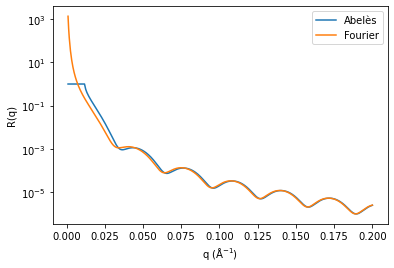

In [10]:
plt.plot(q, r_abeles, label='Abelès')
plt.plot(q, r_fourier, label='Fourier')
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

The deviation at low $q$-values is much clearer now, when comparing with the Abelès approach, which does not rely on the Born approximation. 
Instead, this approach makes use of the refraction of the neutron waves at a series of interfaces, based on the scattering length density of the materials. 